### Supervised Learning - Neural Networks

*Nikola Savic at gmail dot com*

## Imports

In [147]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.neural_network import MLPClassifier

## Fetch, Split and Standardize Data

In [4]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}

## Shared Functions

In [5]:
def print_cross_val(clf, data_set, cv=5, v=1):
    print(clf)
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=-1)
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

In [6]:
def build_confusion_matrix(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize="true", cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [7]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [8]:
def build_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5, title=None):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    if title is None:
        plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    else:
        plt.title(title)

    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

    plt.plot(param_range, test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=float(train_scores_max_x), linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (float(train_scores_max_x), train_scores_max + 0.05))
   
    plt.axvline(x=float(test_scores_max_x), linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (float(test_scores_max_x), test_scores_max - 0.05))

    plt.legend(loc="best")
    plt.show()

In [253]:
def build_logx_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5, title=None):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    if title is None:
        plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    else:
        plt.title(title)

    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

    plt.semilogx(param_range, test_scores_mean, label="Test score", color="navy", lw=lw)

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=float(train_scores_max_x), linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (float(train_scores_max_x), train_scores_max + 0.05))
   
    plt.axvline(x=float(test_scores_max_x), linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (float(test_scores_max_x), test_scores_max - 0.05))

    plt.legend(loc="best")
    plt.show()

In [10]:
def build_nn_two_layer_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5, title=None):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    if title is None:
        plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    else:
        plt.title(title)

    plt.xlabel("# Nodes in each hidden layer (2 layers total)")
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot([x[0] for x in param_range], train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.plot([x[0] for x in param_range], test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    
    plt.axvline(x=float(train_scores_max_x[0]), linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (float(train_scores_max_x[0]), train_scores_max + 0.05))
   
    plt.axvline(x=float(test_scores_max_x[0]), linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (float(test_scores_max_x[0]), test_scores_max - 0.05))

    plt.legend(loc="best")
    plt.show()

In [193]:
def build_nn_multi_layer_validation_curve(clf, data_set, param_range, param_name="hidden_layer_sizes", scoring="accuracy", cv=5, title=None):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]
    
    layers = len(param_range[0])

    if title is None:
        plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    else:
        plt.title(title)

    plt.xlabel("# Nodes in each hidden layer ({} layers total)".format(layers))
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot([x[0] for x in param_range], train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.plot([x[0] for x in param_range], test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    
    plt.axvline(x=float(train_scores_max_x[0]), linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (float(train_scores_max_x[0]), train_scores_max + 0.05))
   
    plt.axvline(x=float(test_scores_max_x[0]), linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (float(test_scores_max_x[0]), test_scores_max - 0.05))

    plt.legend(loc="best")
    plt.show()

In [11]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(MLPClassifier(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

In [84]:
def build_cred_precision_recall_curve(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)
    
    clf.fit(X_train, y_train)
    y_score = clf.predict(X_test)
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('{0} Precision-Recall curve'.format(name))

## cross_val scores - accuracy

In [248]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
print_cross_val(cnn, cred)

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


MLPClassifier : Credit Train
Scores:  [0.70625 0.73125 0.75    0.78125 0.7    ] Avg:  0.73375


In [38]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
print_cross_val(mnn, mnist)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished


MLPClassifier : MNIST Train
Scores:  [0.98196429 0.97946429 0.979375   0.98169643 0.98035714] Avg:  0.9805714285714286


## Learning Curves

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


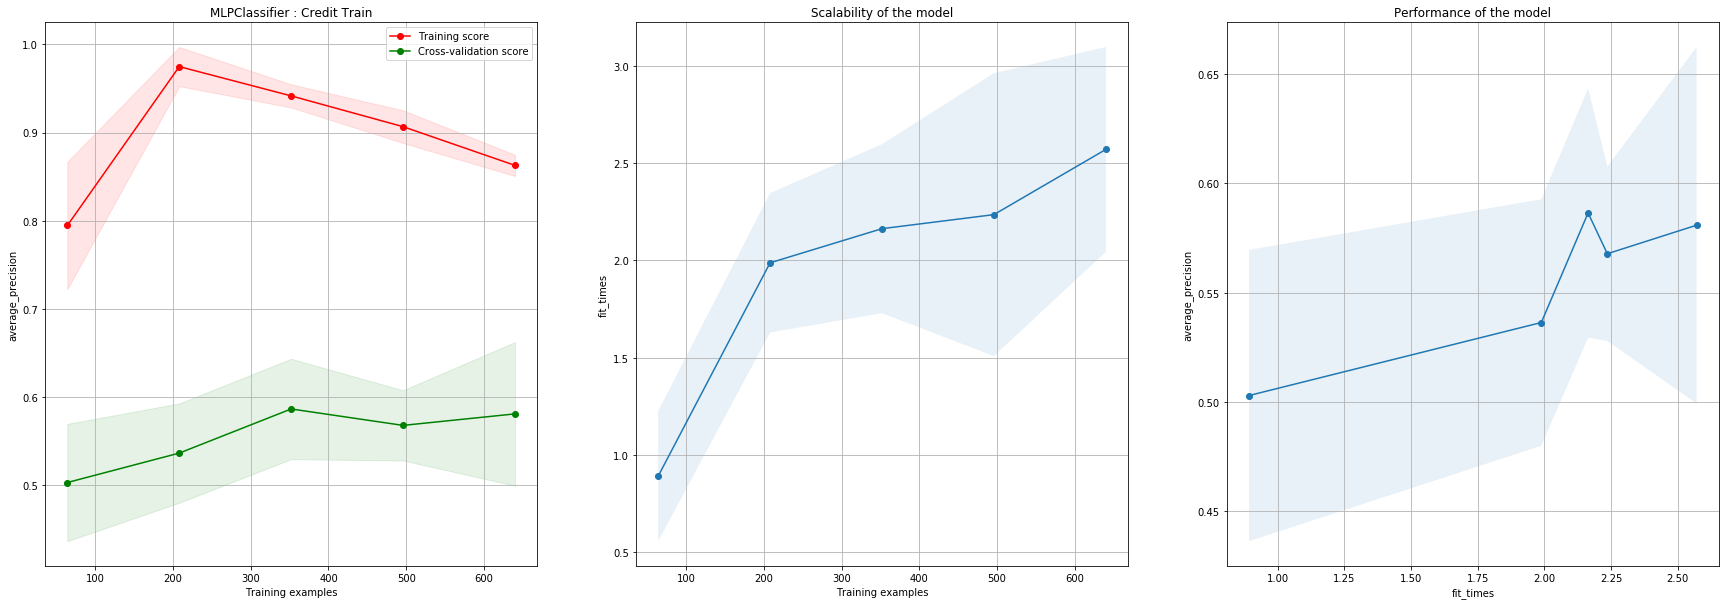

In [246]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_learning_curve(cnn, cred, scoring="average_precision")

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


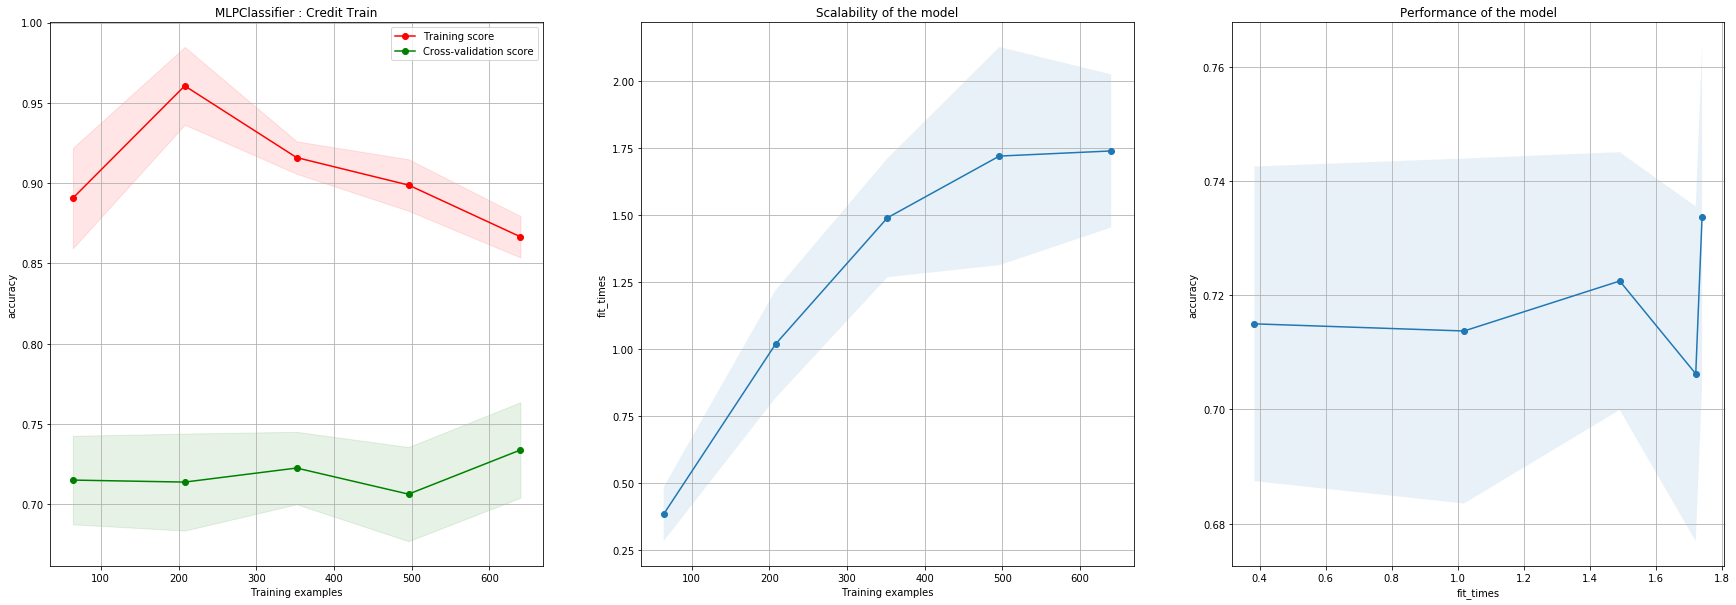

In [247]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_learning_curve(cnn, cred)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


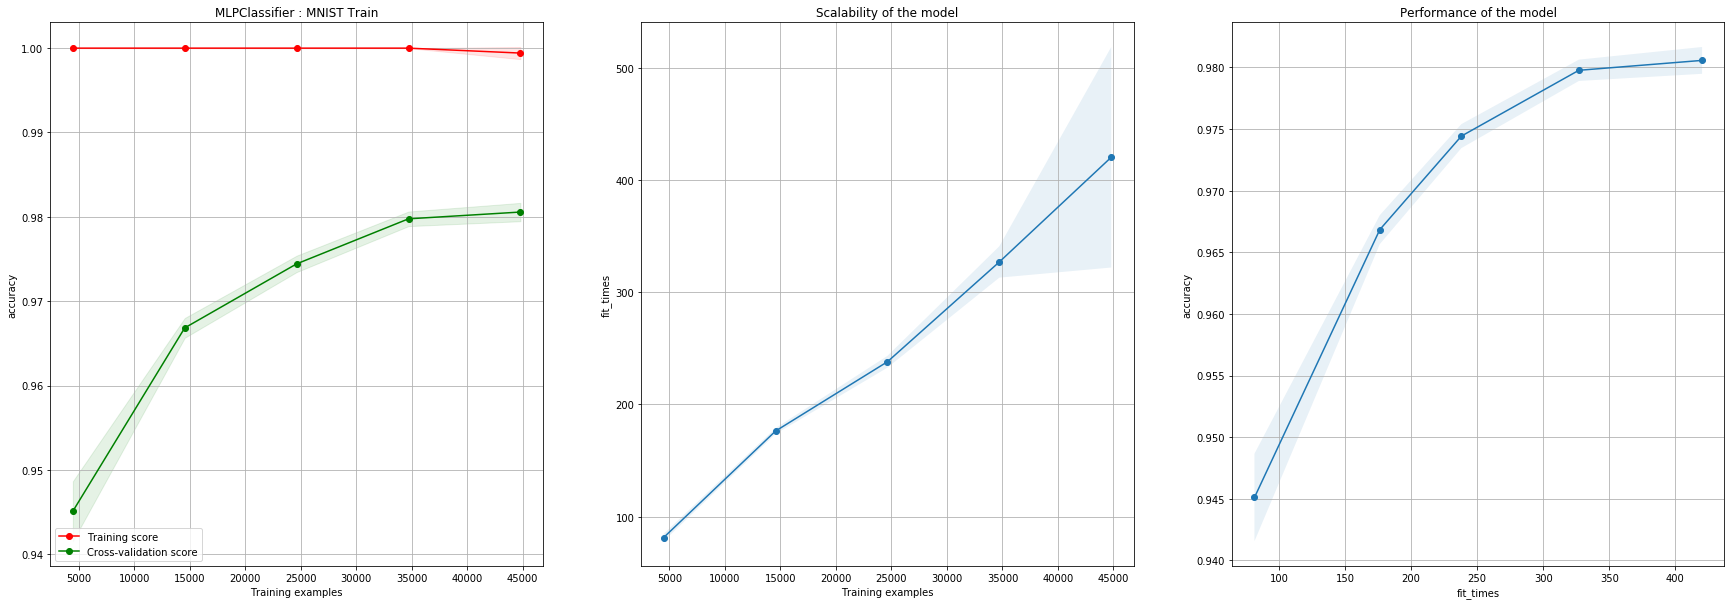

In [39]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_learning_curve(mnn, mnist)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(230, 230, 230), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


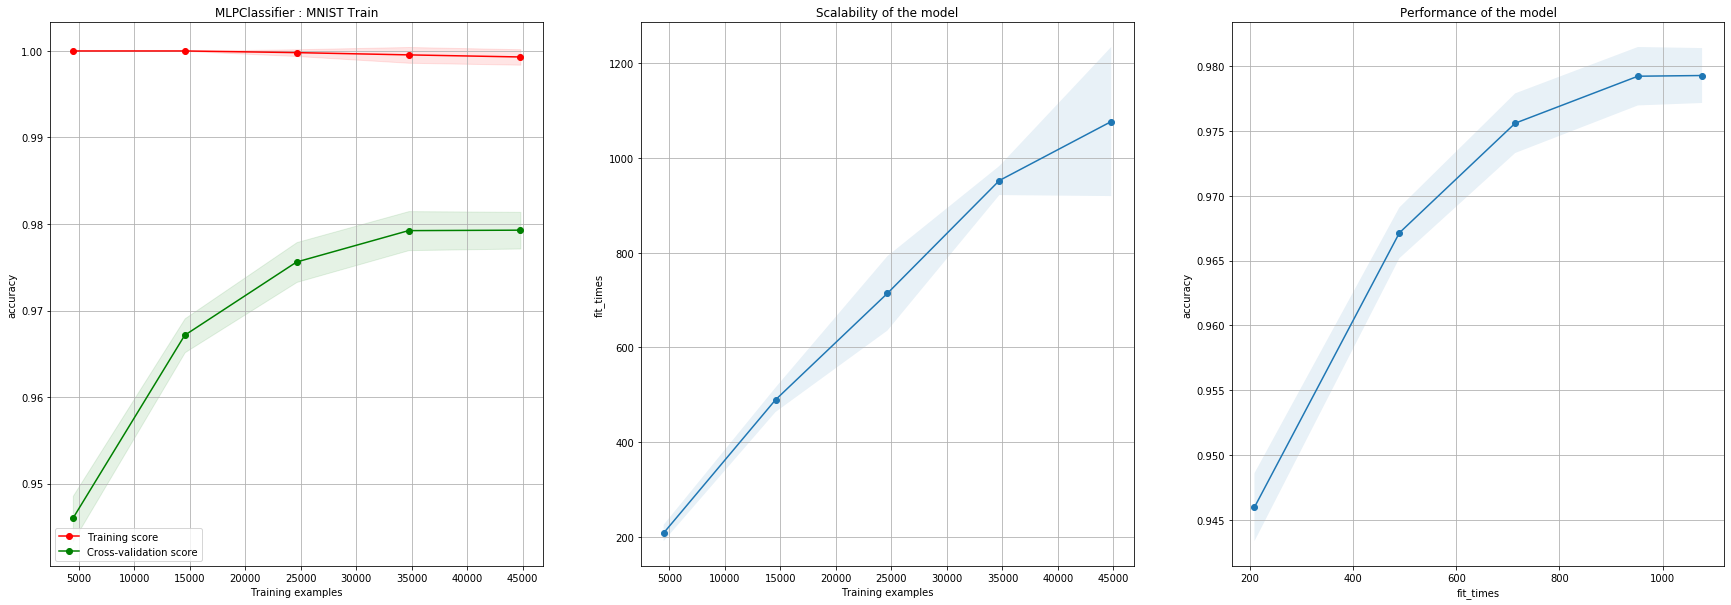

In [205]:
hidden_layer_sizes = (230, 230, 230)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_learning_curve(mnn, mnist)

## Model Complexity Analysis

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


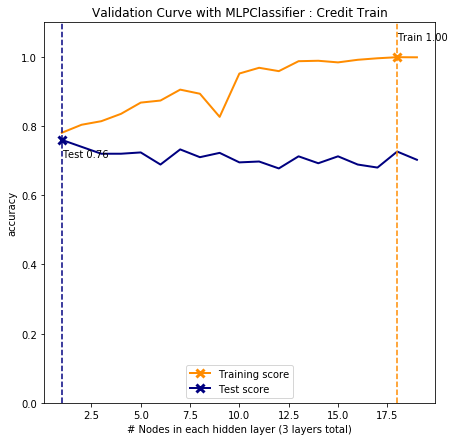

In [263]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_nn_multi_layer_validation_curve(cnn, cred, param_range=[(x,x,x) for x in range(1,20)])

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


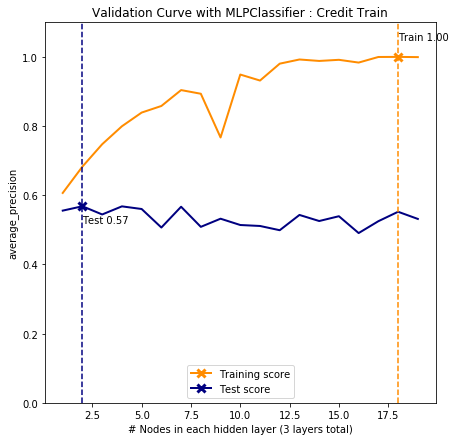

In [264]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_nn_multi_layer_validation_curve(cnn, cred, param_range=[(x,x,x) for x in range(1,20)], scoring="average_precision")

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


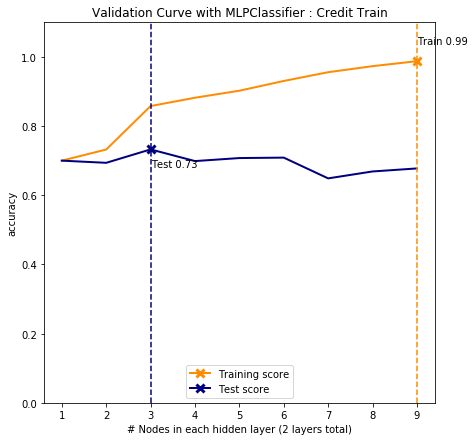

In [195]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    random_state=random_state)
build_nn_multi_layer_validation_curve(cnn, cred, param_range=[(x,x) for x in range(1,10)])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


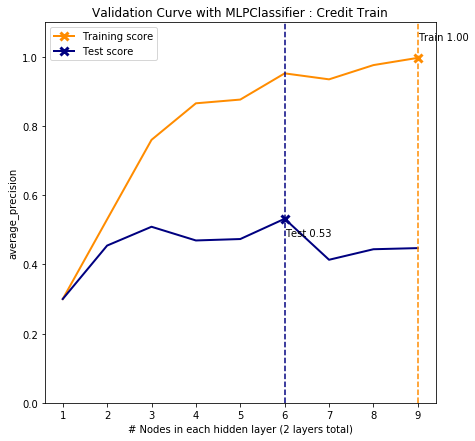

In [249]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    random_state=random_state)
build_nn_multi_layer_validation_curve(cnn, cred, param_range=[(x,x) for x in range(1,10)], scoring="average_precision")

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


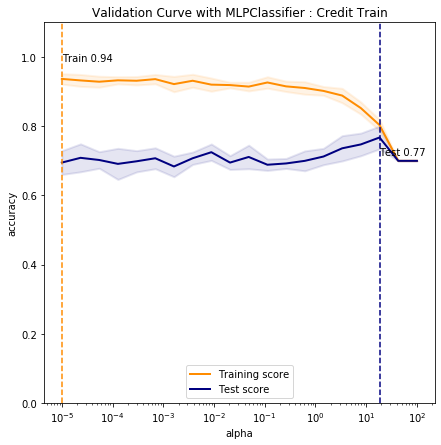

In [254]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_logx_validation_curve(cnn, cred ,param_name="alpha", param_range=np.logspace(-5,2,20))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


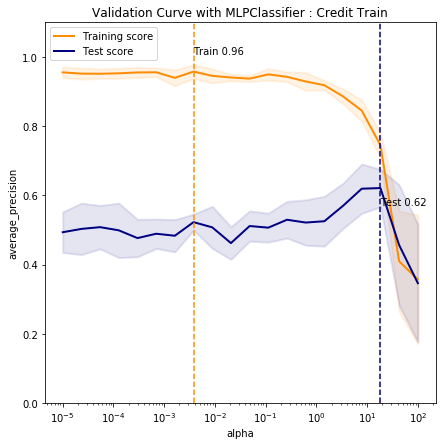

In [255]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_logx_validation_curve(cnn, cred ,param_name="alpha", param_range=np.logspace(-5,2,20), scoring="average_precision")

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


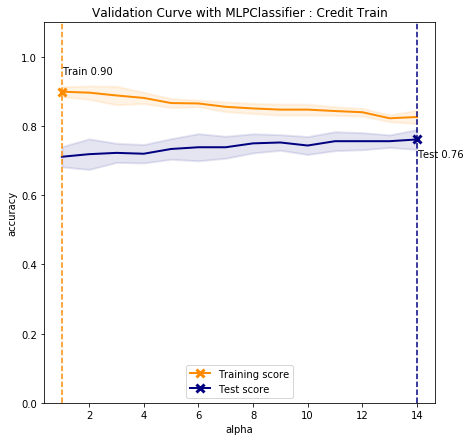

In [239]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_validation_curve(cnn, cred, param_name="alpha", param_range=range(1,15))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


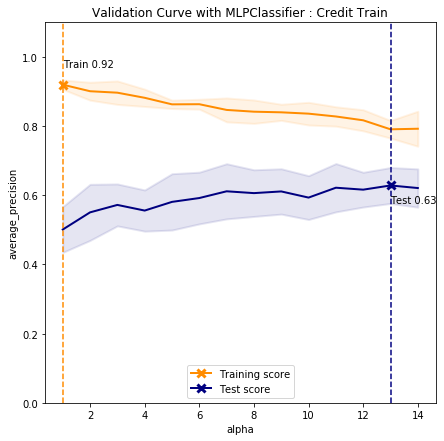

In [240]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_validation_curve(cnn, cred, param_name="alpha", scoring="average_precision", param_range=range(1,15))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


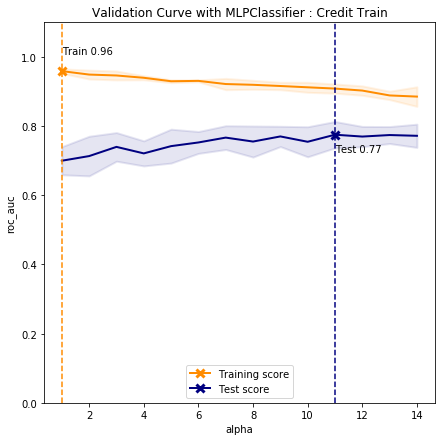

In [241]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_validation_curve(cnn, cred, param_name="alpha", scoring="roc_auc", param_range=range(1,15))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


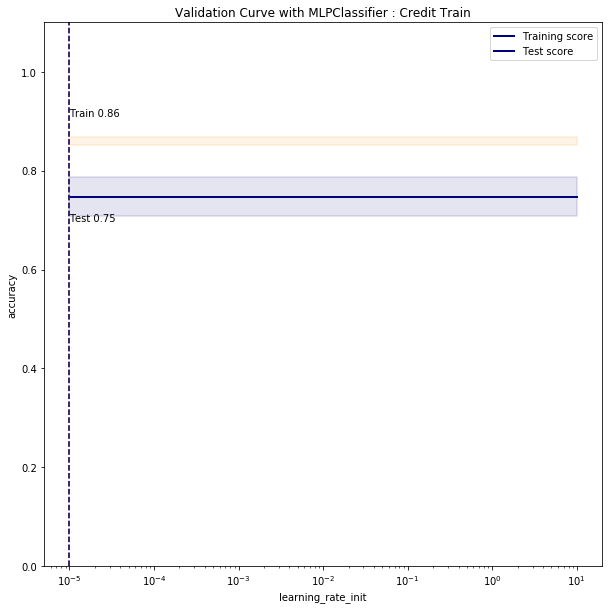

In [127]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_logx_validation_curve(cnn, cred ,param_name="learning_rate_init", param_range=np.logspace(-5,1,20))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


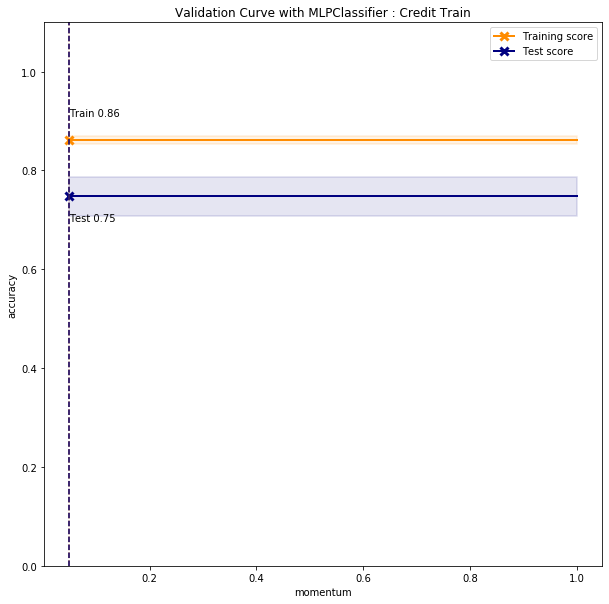

In [128]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_validation_curve(cnn, cred ,param_name="momentum", param_range=np.linspace(0.05,1,20))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


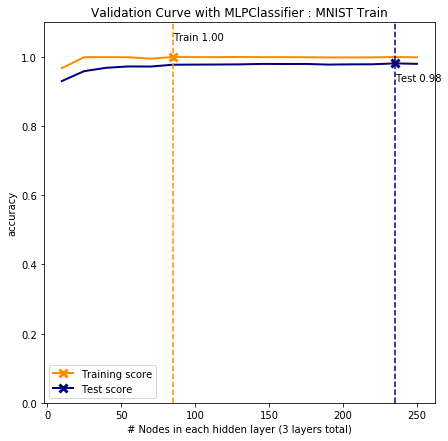

In [198]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_nn_multi_layer_validation_curve(mnn, mnist, param_range=[(x,x,x) for x in range(10,260,15)])

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(265,), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


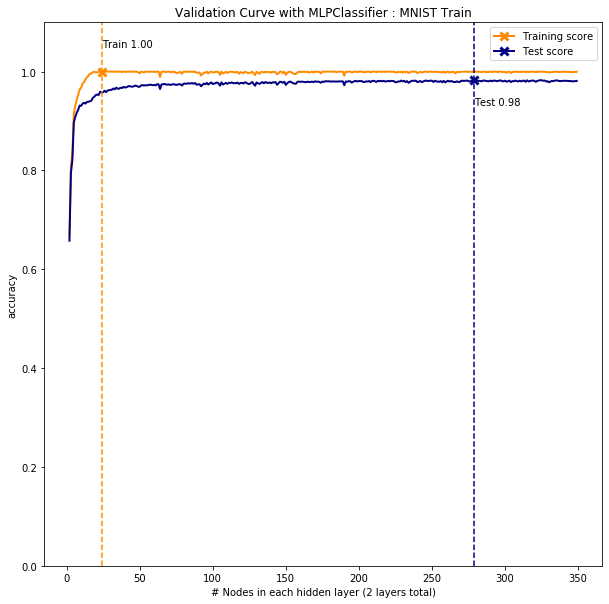

In [36]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_nn_two_layer_validation_curve(mnn, mnist, param_name="hidden_layer_sizes", param_range=[(x,x) for x in range(2,350)])

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


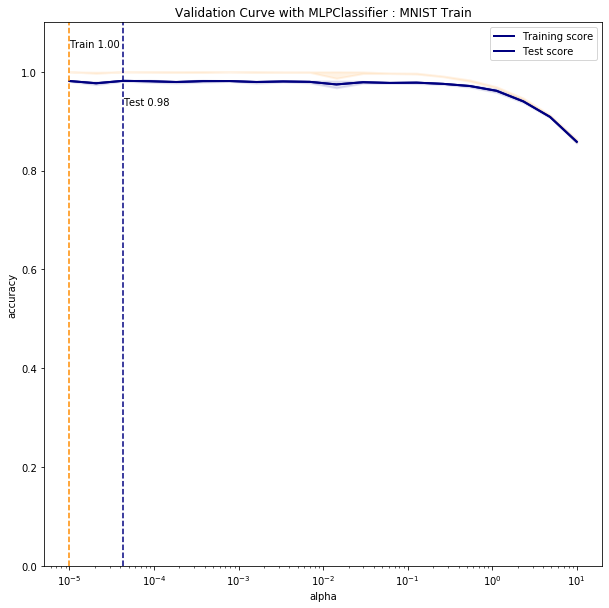

In [63]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_logx_validation_curve(mnn, mnist, param_name="alpha", param_range=np.logspace(-5,1,20))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


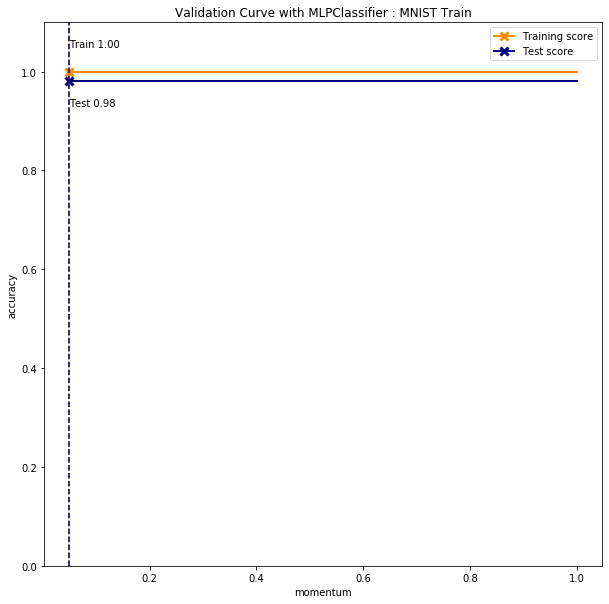

In [55]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_validation_curve(mnn, mnist, param_name="momentum", param_range=np.linspace(0.05,1,20))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


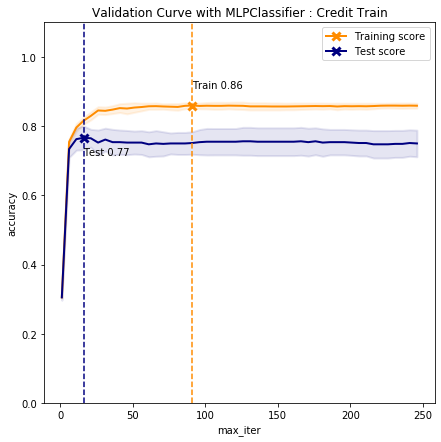

In [164]:
hidden_layer_sizes = (5, 5)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_validation_curve(cnn, cred, param_name="max_iter", param_range=range(1,250,5))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


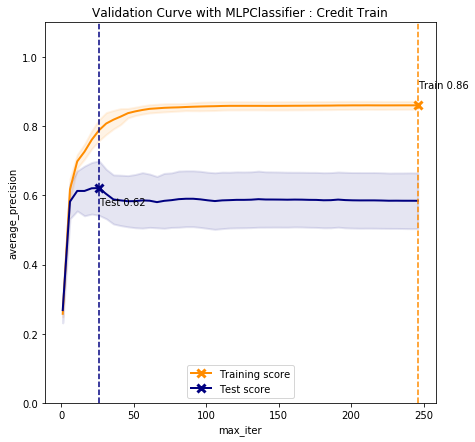

In [257]:
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    random_state=random_state)
build_validation_curve(cnn, cred, param_name="max_iter", param_range=range(1,250,5), scoring="average_precision")

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


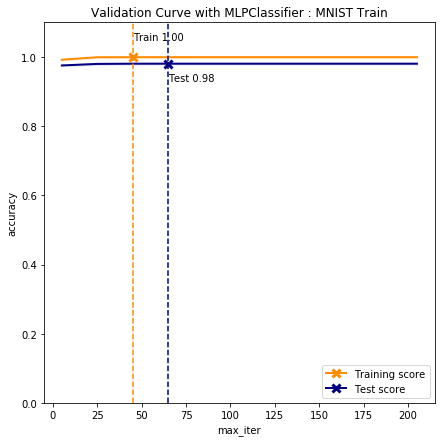

In [165]:
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
build_validation_curve(mnn, mnist, param_name="max_iter", param_range=range(5,210,20))

## Grid Search

In [ ]:
parameters = {
    "hidden_layer_sizes": (6, 6)
}
tuned_parameters =  {
    "learning_rate_init": [0.1, 0.5, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    "alpha": [0.1, 0.5, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    "solver": ["sgd", "adam", "lbfgs"],
    "momentum": np.linspace(0.1,1,10),
    "learning_rate": ["constant", "invscaling", "adaptive"]
}
print_gridsearch(cred, parameters= parameters, tuned_parameters=tuned_parameters, scores = ["accuracy", "average_precision"])

In [ ]:
parameters = {
    "hidden_layer_sizes": (275, 275),
}
tuned_parameters =  {
    "learning_rate_init": [0.001, 0.005, 0.0001, 0.0005],
    "alpha": [0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
#   "momentum": np.linspace(0.1,1,10), # removed to save time, see momemtum validation curve
    "solver": ["sgd", "adam"],
    "learning_rate": ["constant", "invscaling", "adaptive"]
}
print_gridsearch(mnist, parameters=parameters, tuned_parameters=tuned_parameters, scores = ["accuracy"])

## Fit

In [235]:
# Credit Neural Network
hidden_layer_sizes = (6, 6)
solver = "lbfgs"
alpha = 5
cnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    max_iter=max_iter,
                    random_state=random_state)
cnn

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [260]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [236]:
# Fit Credit
X_c, y_c, _ = get_data(cred)
cnn = cnn.fit(X_c, y_c.values.ravel())

In [261]:
# Fit MNIST
X_m, y_m, _ = get_data(mnist)
mnn = mnn.fit(X_m, y_m.values.ravel())

## Final Performance Analysis on TRAINING Set

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


MLPClassifier : Credit Train
Scores:  [0.70625 0.73125 0.75    0.78125 0.7    ] Avg:  0.73375


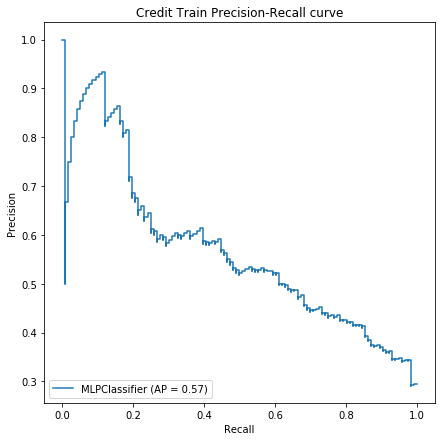

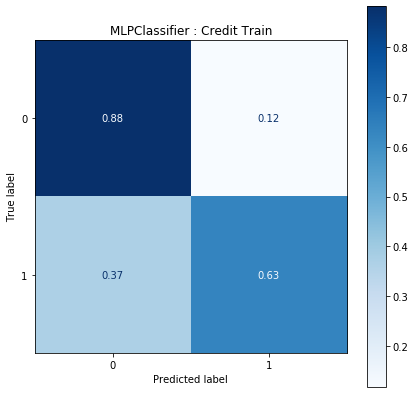

In [237]:
build_cred_precision_recall_curve(cnn, cred)
build_confusion_matrix(cnn, cred)
predicted_cred = cnn.predict(X_cred)
print("Classification report for classifier %s:\n\n%s\n" % (cnn, classification_report(y_cred.values.ravel(), predicted_cred)))
print_cross_val(cnn, cred)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.5min finished


MLPClassifier : MNIST Train
Scores:  [0.98196429 0.97946429 0.979375   0.98169643 0.98035714] Avg:  0.9805714285714286


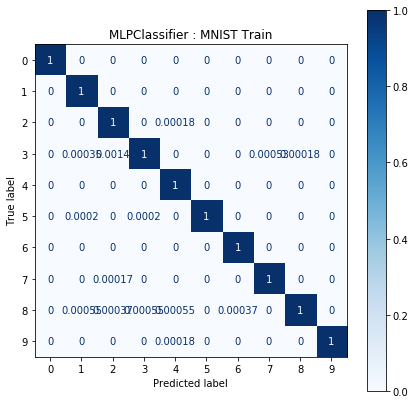

In [169]:
build_confusion_matrix(mnn, mnist)
predicted_mnist = mnn.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (mnn, classification_report(y_mnist, predicted_mnist)))
print_cross_val(mnn, mnist)

## Final Performance Analysis on TEST Set

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=900,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='lbfgs',
              tol

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


MLPClassifier : Credit Test
Scores:  [0.725 0.7   0.725 0.75  0.65 ] Avg:  0.71


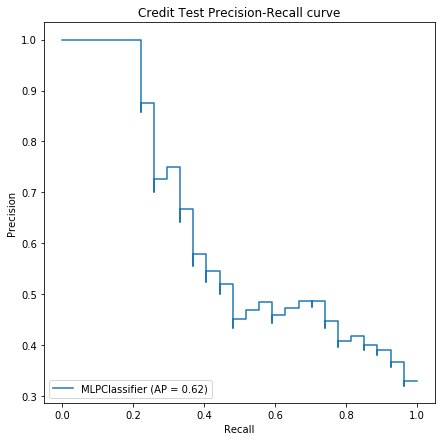

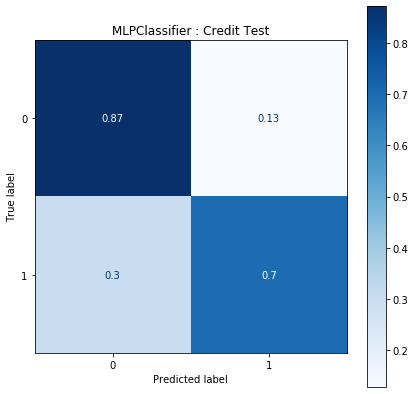

In [238]:
build_cred_precision_recall_curve(cnn, cred_test)
build_confusion_matrix(cnn, cred_test)
predicted_cred = cnn.predict(X_cred_test)
print("Classification report for classifier %s:\n\n%s\n" % (cnn, classification_report(y_cred_test, predicted_cred)))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

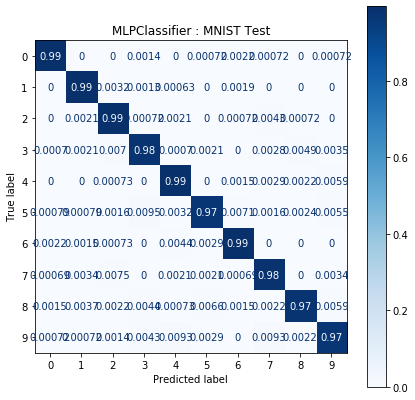

In [262]:
build_confusion_matrix(mnn, mnist_test)
predicted_mnist = mnn.predict(X_mnist_test)
print("Classification report for classifier %s:\n\n%s\n" % (mnn, classification_report(y_mnist_test, predicted_mnist, digits=3)))